In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

Don't need the replace function in HS all values are cleaned.

In [2]:
def process_batting_data(file_path):
    # Load the data
    data = pd.read_excel(file_path)
    print("Original columns:", data.columns.tolist())
    
    # Work directly with the Excel data
    df = data.copy()
    
    # Define essential columns that should be present in both datasets
    essential_columns = ['Player', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', 
                        "100s", "50s", 0, '4s', '6s']
    
    # Verify all essential columns exist
    missing_cols = [col for col in essential_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing essential columns: {missing_cols}")
    
    # Print original HS values for verification
    print("\nBefore processing - Sample HS values:")
    print(df[['Player', 'HS']].head(10))
    
    # Clean and convert HS data more carefully
    def clean_hs(value):
        if pd.isna(value) or value == '-':
            return 0
        # Remove '*' if present and convert to string
        value = str(value).replace('*', '')
        # Convert to integer
        try:
            return int(value)
        except ValueError:
            print(f"Warning: Could not convert HS value '{value}' to integer")
            return 0
    
    # Apply the cleaning function to HS column
    df['HS'] = df['HS'].apply(clean_hs)
    
    # Print processed HS values for verification
    print("\nAfter processing - Sample HS values:")
    print(df[['Player', 'HS']].head(10))
    
    # Replace '-' with 0 in other numeric columns
    numeric_columns = ['Mat', 'Inns', 'NO', 'Runs', 'Ave', 'BF', 'SR', "100s", "50s", 0, '4s', '6s']
    for col in numeric_columns:
        df[col] = df[col].replace('-', 0).astype(float)
    
    # Feature Engineering
    df['Dismissals'] = df['Inns'] - df['NO']
    df['RunsPerInning'] = df['Runs'].div(df['Inns'].replace(0, 1))
    df['FiftyPlusPerInning'] = (df["50s"] + df["100s"]).div(df['Inns'].replace(0, 1))
    df['DucksPerInning'] = df[0].div(df['Inns'].replace(0, 1))
    df['BoundaryPercentage'] = df.apply(lambda x: ((x['4s'] * 4) + (x['6s'] * 6)) / x['Runs'] if x['Runs'] != 0 else 0, axis=1)
    df['BallsPerBoundary'] = df.apply(lambda x: x['BF'] / (x['4s'] + x['6s']) if (x['4s'] + x['6s']) != 0 else 0, axis=1)
    df['NonBoundarySR'] = df.apply(lambda x: 
        ((x['Runs']-(x['4s'] * 4) - (x['6s'] * 6))/(x['BF']-x['4s']-x['6s']))*100 
        if (x['BF']-x['4s']-x['6s']) != 0 else 0, axis=1)
    
    return df

In [3]:
def analyze_and_visualize(df):
    # Select Features for Analysis
    features = ['Ave', 'RunsPerInning', 'FiftyPlusPerInning', 'DucksPerInning', 'SR', 
                'NonBoundarySR', 'BoundaryPercentage', 'BallsPerBoundary']
    df_analysis = df[features]
    
    # Replace infinities and NaN with 0
    df_analysis = df_analysis.replace([np.inf, -np.inf], 0)
    df_analysis = df_analysis.fillna(0)
    
    # Correlation Analysis
    correlation_matrix = df_analysis.corr()
    
    # Visualize Correlation Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Features')
    plt.show()
    
    return df_analysis

we don't need this code.

In [4]:
def calculate_ratings(df_analysis, df):
    # Normalize Features
    scaler = MinMaxScaler()
    features = df_analysis.columns
    df_normalized = pd.DataFrame(scaler.fit_transform(df_analysis), columns=features)
    df_normalized['Player'] = df['Player']
    
    # Calculate Scores
    df_normalized['Consistency'] = (0.4 * df_normalized['Ave']) + \
                                 (0.3 * df_normalized['FiftyPlusPerInning']) + \
                                 (0.1 * df_normalized['NonBoundarySR'])
    df_normalized['Form'] = (0.6 * df_normalized['Ave']) + (0.4 * df_normalized['SR'])
    df_normalized['Overall_Rating'] = (0.7 * df_normalized['Consistency']) + (0.3 * df_normalized['Form'])
    
    # Return Results
    return df_normalized[['Player', 'Consistency', 'Form', 'Overall_Rating']].sort_values(
        by='Overall_Rating', ascending=False)


Processing All Seasons Dataset:
Original columns: ['Player', 'Span', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', '100s', '50s', 0, '4s', '6s']

Before processing - Sample HS values:
           Player   HS
0         V Kohli  113
1        S Dhawan  106
2       RG Sharma  109
3       DA Warner  126
4        SK Raina  100
5        MS Dhoni   84
6  AB de Villiers  133
7        CH Gayle  175
8      RV Uthappa   88
9      KD Karthik   97

After processing - Sample HS values:
           Player   HS
0         V Kohli  113
1        S Dhawan  106
2       RG Sharma  109
3       DA Warner  126
4        SK Raina  100
5        MS Dhoni   84
6  AB de Villiers  133
7        CH Gayle  175
8      RV Uthappa   88
9      KD Karthik   97


/var/folders/mk/9dydvdvn7ldgkc8zfmkv95fh0000gn/T/ipykernel_7424/2148387352.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('-', 0).astype(float)
/var/folders/mk/9dydvdvn7ldgkc8zfmkv95fh0000gn/T/ipykernel_7424/2148387352.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('-', 0).astype(float)
/var/folders/mk/9dydvdvn7ldgkc8zfmkv95fh0000gn/T/ipykernel_7424/2148387352.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version

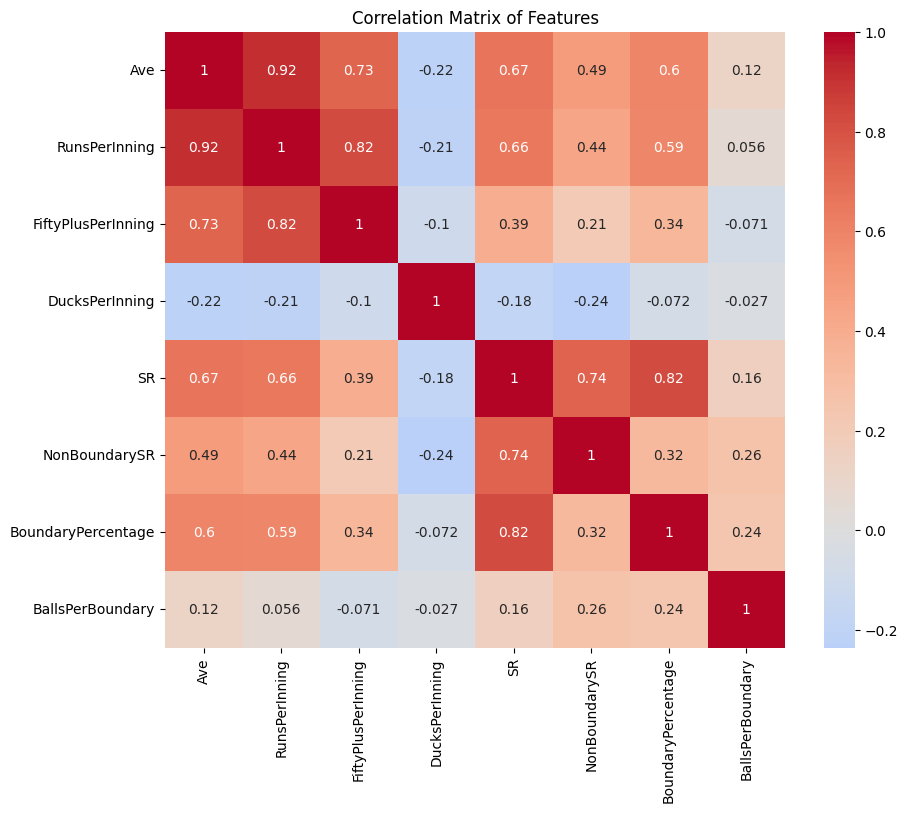


All Seasons Ratings:
              Player  Consistency      Form  Overall_Rating
344   Vivrant Sharma     0.738889  0.795733        0.755942
252       MN van Wyk     0.433262  0.652680        0.499087
104        DP Conway     0.448831  0.611243        0.497554
91   B Sai Sudharsan     0.407031  0.594242        0.463194
10          KL Rahul     0.408741  0.574771        0.458550
..               ...          ...       ...             ...
674          K Yadav     0.000000  0.000000        0.000000
673     TP Sudhindra     0.000000  0.000000        0.000000
672           KR Sen     0.000000  0.000000        0.000000
671   R Sanjay Yadav     0.000000  0.000000        0.000000
734         MP Yadav     0.000000  0.000000        0.000000

[735 rows x 4 columns]


In [5]:
try:
    print("\nProcessing All Seasons Dataset:")
    all_seasons_df = process_batting_data('../../all seasons/battingAllSeasons.xlsx')
    all_seasons_analysis = analyze_and_visualize(all_seasons_df)
    all_seasons_ratings = calculate_ratings(all_seasons_analysis, all_seasons_df)
    print("\nAll Seasons Ratings:")
    print(all_seasons_ratings)
except Exception as e:
    print(f"Error processing all seasons data: {str(e)}")

/var/folders/mk/9dydvdvn7ldgkc8zfmkv95fh0000gn/T/ipykernel_7424/2148387352.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('-', 0).astype(float)



Processing Last Season Dataset:
Original columns: ['Player', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', '100s', '50s', 0, '4s', '6s']

Before processing - Sample HS values:
            Player   HS
0          V Kohli  113
1       RD Gaikwad  108
2          R Parag   84
3          TM Head  102
4        SV Samson   86
5  B Sai Sudharsan  103
6         KL Rahul   82
7         N Pooran   75
8        SP Narine  109
9  Abhishek Sharma   75

After processing - Sample HS values:
            Player   HS
0          V Kohli  113
1       RD Gaikwad  108
2          R Parag   84
3          TM Head  102
4        SV Samson   86
5  B Sai Sudharsan  103
6         KL Rahul   82
7         N Pooran   75
8        SP Narine  109
9  Abhishek Sharma   75


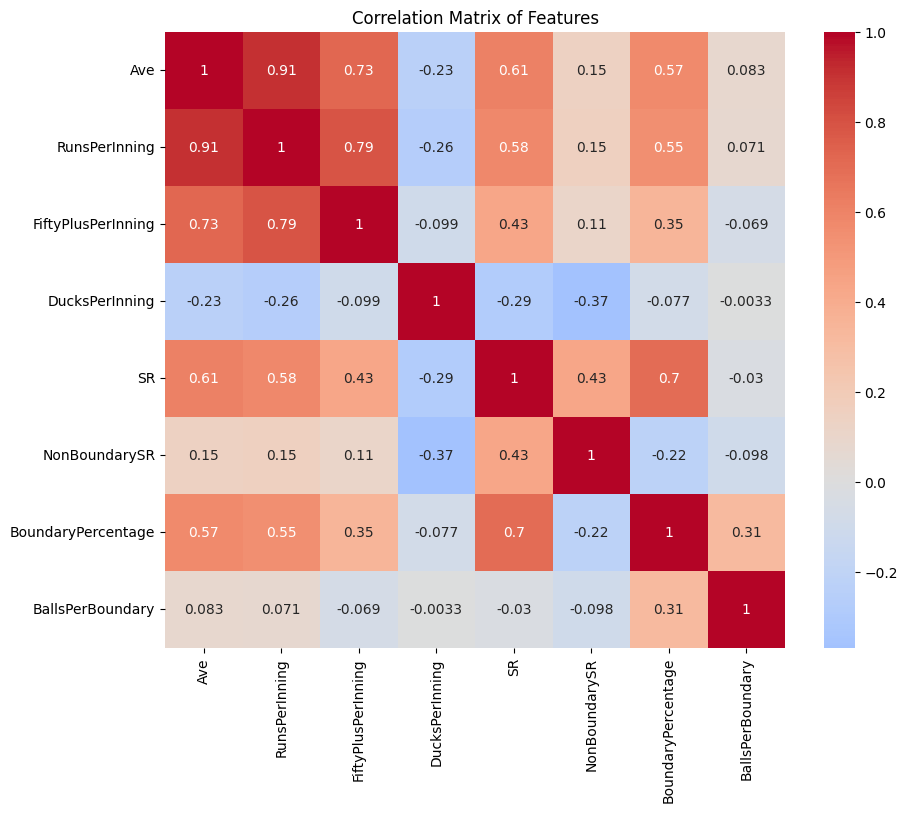


Last Season Ratings:
                Player  Consistency      Form  Overall_Rating
0              V Kohli     0.700984  0.800289        0.730776
7             N Pooran     0.578853  0.837613        0.656481
1           RD Gaikwad     0.617032  0.698074        0.641344
21            T Stubbs     0.544657  0.774014        0.613464
2              R Parag     0.561494  0.700053        0.603062
..                 ...          ...       ...             ...
157          MM Sharma     0.013080  0.027393        0.017374
163           I Sharma     0.007143  0.019040        0.010712
167           MJ Dagar     0.000000  0.000000        0.000000
168       TU Deshpande     0.000000  0.000000        0.000000
169  Washington Sundar     0.000000  0.000000        0.000000

[170 rows x 4 columns]


In [6]:
try:
    print("\nProcessing Last Season Dataset:")
    last_season_df = process_batting_data('/Users/dog/Documents/CricketSquadSelection/lastseason/lastseasoniplbatting.xlsx')
    last_season_analysis = analyze_and_visualize(last_season_df)
    last_season_ratings = calculate_ratings(last_season_analysis, last_season_df)
    print("\nLast Season Ratings:")
    print(last_season_ratings)
except Exception as e:
    print(f"Error processing last season data: {str(e)}")

In [7]:
def calculate_metrics(all_seasons_df):
    # Create a copy of the input dataframe
    all_seasons_df = all_seasons_df.copy()
    
    # Keep only the most recent record for each player
    all_seasons_unique = all_seasons_df.sort_values('Mat', ascending=False).drop_duplicates(
        subset=['Player'], keep='first'
    )
    
    # Define features for consistency calculation
    combined_features = ['Ave', 'FiftyPlusPerInning', 'NonBoundarySR']
    
    # Handle any NaN or infinite values before scaling
    combined_data = all_seasons_unique[combined_features].replace([np.inf, -np.inf], 0).fillna(0)
    
    # Normalize data
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(
        scaler.fit_transform(combined_data),
        columns=combined_features
    )
    normalized_data['Player'] = all_seasons_unique['Player']
    
    # Calculate Consistency
    normalized_data['Consistency'] = (
        0.4 * normalized_data['Ave'] +
        0.3 * normalized_data['FiftyPlusPerInning'] +
        0.1 * normalized_data['NonBoundarySR']
    )
    
    # Return only Player and Consistency columns
    consistency_df = normalized_data[['Player', 'Consistency']].drop_duplicates(subset=['Player'], keep='first')
    
    return consistency_df

# Calculate metrics and process data
try:
    # Calculate consistency
    consistency_ratings = calculate_metrics(all_seasons_df)
    
    # Process all seasons data
    all_seasons_processed = all_seasons_df.copy()
    all_seasons_processed = all_seasons_processed.merge(
        consistency_ratings,
        on='Player',
        how='left'
    )
    
    print("\nSample of All Seasons processed data (with Consistency):")
    print(all_seasons_processed[['Player', 'Consistency']].head())
    
    # Save the processed data
    def save_processed_data(all_seasons_df):
        # Save all seasons data
        all_seasons_path = "../../all seasons/batsamset_ipl.xlsx"
    def save_processed_data( all_seasons_df):
        # Create base directory
        base_dir = '/Users/dog/Documents/CricketSquadSelection/processed_data'
        os.makedirs(base_dir, exist_ok=True)
        
        # Generate timestamp
        
        # Save all seasons data (includes only Consistency)
        all_seasons_path = "../../all seasons/batsamset_ipl.xlsx"
        all_seasons_df.to_excel(all_seasons_path, index=False)
        print(f"All seasons data saved to: {all_seasons_path}")
    
    # Save the processed data
    save_processed_data(all_seasons_processed)
    
except Exception as e:
    print(f"Error in calculation: {str(e)}")


Sample of All Seasons processed data (with Consistency):
      Player  Consistency
0    V Kohli     0.305747
1   S Dhawan     0.266612
2  RG Sharma     0.226196
3  DA Warner     0.348116
4   SK Raina     0.213282
All seasons data saved to: ../../all seasons/batsamset_ipl.xlsx


In [8]:
# Import required libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy

def calculate_formula_components_for_importance(player_data):
    """
    Calculates the components of the consistency formula as features for feature importance.
    """
    df = player_data.copy()
    max_hs = df['HS'].max()
    max_ave = df['Ave'].max()

    df['Innings_per_Match'] = df['Inns'] / df['Mat']
    df['NotOut_per_Innings'] = df['NO'] / df['Inns']
    df['Runs_per_BallsFaced'] = df['Runs'] / df['BF']
    df['HighScore_Relative'] = df['HS'] / max_hs if max_hs > 0 else 0
    df['Average_Relative'] = df['Ave'] / max_ave if max_ave > 0 else 0
    # Use np.where for element-wise conditional calculation to avoid ValueError
    df['Milestones_per_Innings'] = np.where(df['Inns'] > 0, (df['50s'] + 2 * df['100s']) / df['Inns'], 0)
    df['Ducks_per_Innings'] = np.where(df['Inns'] > 0, df.iloc[:,df.columns.get_loc(0)] / df['Inns'], 0)

    feature_components_df = df[[
        'Innings_per_Match',
        'NotOut_per_Innings',
        'Runs_per_BallsFaced',
        'HighScore_Relative',
        'Average_Relative',
        'Milestones_per_Innings',
        'Ducks_per_Innings'
    ]]

    return feature_components_df

# Assuming 'all_seasons_processed' DataFrame is already loaded and 'Consistency' column exists

# Calculate formula components using all_seasons_processed data
feature_components_df = calculate_formula_components_for_importance(all_seasons_processed)
X = feature_components_df
feature_names = X.columns.tolist()

# Use Consistency as target variable
y = all_seasons_processed['Consistency']

# Remove rows where either X or y contains NaN values
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

# Dictionary to store feature importances for each model
all_feature_importances = {}

# Loop through models
for model_name, model in models.items():
    print(f"--- {model_name} ---")

    # Train model
    model.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error on Test Set: {mse:.4f}")

    # Extract feature importances (or coefficients for linear models)
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        normalized_importances = importances / importances.sum()
        print("\nFeature Importances (Normalized Percentage):")
        print(normalized_importances)
        all_feature_importances[model_name] = normalized_importances
    elif hasattr(model, 'coef_'): # For linear models, use coefficients as importance proxy
        importances = pd.Series(abs(model.coef_), index=feature_names).sort_values(ascending=False) # Absolute value of coefficients
        normalized_importances = importances / importances.sum() if importances.sum() > 0 else importances # Normalize if sum is not zero
        print("\nFeature Importances (based on absolute coefficients, Normalized Percentage):")
        print(normalized_importances )
        all_feature_importances[model_name] = normalized_importances
    else:
        print("\nFeature importances not available for this model.")
        all_feature_importances[model_name] = None # Indicate no importances available

    print("\n")

# Optional: Compare feature importances across models visually or numerically if needed
# For example, you can create a DataFrame from all_feature_importances and plot it.
# comparison_df = pd.DataFrame(all_feature_importances)
# print(comparison_df)
# comparison_df.plot(kind='bar', figsize=(12, 6))

--- Linear Regression ---
Mean Squared Error on Test Set: 0.0062

Feature Importances (based on absolute coefficients, Normalized Percentage):
HighScore_Relative        0.621318
Milestones_per_Innings    0.276452
Average_Relative          0.057297
Ducks_per_Innings         0.023654
NotOut_per_Innings        0.011306
Innings_per_Match         0.008946
Runs_per_BallsFaced       0.001027
dtype: float64


--- Ridge Regression ---
Mean Squared Error on Test Set: 0.0062

Feature Importances (based on absolute coefficients, Normalized Percentage):
HighScore_Relative        0.669251
Milestones_per_Innings    0.165730
Average_Relative          0.099601
Ducks_per_Innings         0.028905
NotOut_per_Innings        0.020299
Runs_per_BallsFaced       0.012174
Innings_per_Match         0.004040
dtype: float64


--- Decision Tree Regressor ---
Mean Squared Error on Test Set: 0.0110

Feature Importances (Normalized Percentage):
HighScore_Relative        0.333907
Average_Relative          0.195399
Runs

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy

def calculate_formula_components_for_importance(player_data):
    """
    Calculates the components of the consistency formula as features for feature importance.
    """
    df = player_data.copy()
    max_hs = df['HS'].max()
    max_ave = df['Ave'].max()

    df['Innings_per_Match'] = df['Inns'] / df['Mat']
    df['NotOut_per_Innings'] = df['NO'] / df['Inns']
    df['Runs_per_BallsFaced'] = df['Runs'] / df['BF']
    df['HighScore_Relative'] = df['HS'] / max_hs if max_hs > 0 else 0
    df['Average_Relative'] = df['Ave'] / max_ave if max_ave > 0 else 0
    # Use np.where for element-wise conditional calculation to avoid ValueError
    df['Milestones_per_Innings'] = np.where(df['Inns'] > 0, (df['50s'] + 2 * df['100s']) / df['Inns'], 0)
    df['Ducks_per_Innings'] = np.where(df['Inns'] > 0, df.columns.get_loc(0) / df['Inns'], 0)

    feature_components_df = df[[
        'Innings_per_Match',
        'NotOut_per_Innings',
        'Runs_per_BallsFaced',
        'HighScore_Relative',
        'Average_Relative',
        'Milestones_per_Innings',
        'Ducks_per_Innings'
    ]]

    return feature_components_df

# Assuming 'all_seasons_processed' DataFrame is already loaded and 'Consistency' column exists

# Calculate formula components using all_seasons_processed data
feature_components_df = calculate_formula_components_for_importance(all_seasons_processed)
X = feature_components_df
feature_names = X.columns.tolist()

# Use Consistency as target variable
y = all_seasons_processed['Consistency']

# Remove rows where either X or y contains NaN values
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

# Dictionary to store feature importances and MSE for each model
all_feature_importances = {}
model_mses = {}

# Loop through models
for model_name, model in models.items():
    print(f"--- {model_name} ---")

    # Train model
    model.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error on Test Set: {mse:.4f}")
    model_mses[model_name] = mse

    # Extract feature importances (or coefficients for linear models)
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        normalized_importances = importances / importances.sum()
        all_feature_importances[model_name] = normalized_importances
    elif hasattr(model, 'coef_'): # For linear models, use coefficients as importance proxy
        importances = pd.Series(abs(model.coef_), index=feature_names).sort_values(ascending=False) # Absolute value of coefficients
        normalized_importances = importances / importances.sum() if importances.sum() > 0 else importances # Normalize if sum is not zero
        all_feature_importances[model_name] = normalized_importances
    else:
        print("\nFeature importances not available for this model.")
        all_feature_importances[model_name] = None # Indicate no importances available

    print("\n")

# --- Workflow for Weight Selection ---

print("--- Weight Selection Workflow ---")

# 1. Print MSEs for all models to identify best performing model
print("\nModel Mean Squared Errors (MSE):")
for model_name, mse in model_mses.items():
    print(f"{model_name}: {mse:.4f}")

best_model_name = min(model_mses, key=model_mses.get) # Model with lowest MSE
print(f"\nBest Performing Model (Lowest MSE): {best_model_name}")

# 2. Calculate and print Average Feature Importances across all models
average_importances = pd.DataFrame(all_feature_importances).mean(axis=1).sort_values(ascending=False)
normalized_average_importances = average_importances / average_importances.sum()
print("\nAverage Feature Importances (Normalized Percentage across Models):")
print(normalized_average_importances * 100)
average_weights = normalized_average_importances.to_dict() # Store as dict for easy access

# 3. Print Feature Importances from the Best Performing Model
best_model_importances = all_feature_importances[best_model_name]
print(f"\nFeature Importances from Best Model ({best_model_name}, Normalized Percentage):")
print(best_model_importances * 100)
best_model_weights = best_model_importances.to_dict() # Store as dict

# 4. Analyze and print Feature Ranking Consistency across models
rankings_df = pd.DataFrame()
for model_name, importances in all_feature_importances.items():
    if importances is not None:
        rankings_df[model_name] = importances.rank(ascending=False)

average_rankings = rankings_df.mean(axis=1).sort_values(ascending=True)
print("\nAverage Feature Rankings Across Models (Lower Rank = More Important):")
print(average_rankings)


# 5. Print all sets of weights for easy comparison and manual selection
print("\n--- Summary of Weights (Normalized Percentage) ---")
print("\nAverage Weights Across Models:")
for name, weight in average_weights.items():
    print(f"{name}: {weight*100:.2f}%")

print(f"\nWeights from Best Model ({best_model_name}):")
for name, weight in best_model_weights.items():
    print(f"{name}: {weight*100:.2f}%")

# Based on the outputs above (MSEs, Average Weights, Best Model Weights, Ranking Consistency),
# you can now manually review and decide which set of weights (or a manually adjusted set)
# you want to use for your final consistency formula.

--- Linear Regression ---
Mean Squared Error on Test Set: 0.0062


--- Ridge Regression ---
Mean Squared Error on Test Set: 0.0062


--- Decision Tree Regressor ---
Mean Squared Error on Test Set: 0.0139


--- Random Forest Regressor ---
Mean Squared Error on Test Set: 0.0071


--- Gradient Boosting Regressor ---
Mean Squared Error on Test Set: 0.0076


--- Weight Selection Workflow ---

Model Mean Squared Errors (MSE):
Linear Regression: 0.0062
Ridge Regression: 0.0062
Decision Tree Regressor: 0.0139
Random Forest Regressor: 0.0071
Gradient Boosting Regressor: 0.0076

Best Performing Model (Lowest MSE): Ridge Regression

Average Feature Importances (Normalized Percentage across Models):
HighScore_Relative        48.673558
Runs_per_BallsFaced       11.438999
Ducks_per_Innings          9.968526
Average_Relative           9.672499
Innings_per_Match          8.118322
NotOut_per_Innings         6.191832
Milestones_per_Innings     5.936264
dtype: float64

Feature Importances from Best Model

## Here the model thats most closer to the average of all the parameters weights are chosen for the calculation of consistency
## Also the random forest regressor model is chosen as it has the least MSE and the highest feature importance
## The weights are:


In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy

def calculate_formula_components_for_importance(player_data):
    """
    Calculates the components of the NEW consistency formula as features for feature importance.
    New Formula: Consistency Score = w1 * (Inns / Mat) + w2 * (NO / Inns) + w3 * (Runs / BF)  + w4 * Ave + w5 * ((50s + 2*100s) / Inns) - w6 * (Zeros / Inns)
    """
    df = player_data.copy()

    df['Inns_per_Match'] = df['Inns'] / df['Mat']
    df['NotOut_per_Innings'] = df['NO'] / df['Inns']
    df['Runs_per_BallsFaced'] = df['Runs'] / df['BF']
    df['Average'] = df['Ave'] # Direct Ave feature
    # Use np.where for element-wise conditional calculation to avoid ValueError
    df['Milestone_per_Inns'] = np.where(df['Inns'] > 0, (df['50s'] + 2 * df['100s']) / df['Inns'], 0) # Renamed to Milestone_per_Inns
    df['Zeros_per_Inns'] = np.where(df['Inns'] > 0, df.columns.get_loc(0) / df['Inns'], 0) # Renamed to Zeros_per_Inns and corrected to use '0' column

    feature_components_df = df[[
        'Inns_per_Match',
        'NotOut_per_Innings',
        'Runs_per_BallsFaced',
        'Average', # Changed to 'Average'
        'Milestone_per_Inns', # Renamed to Milestone_per_Inns
        'Zeros_per_Inns' # Renamed to Zeros_per_Inns
    ]]

    return feature_components_df

# Assuming 'all_seasons_processed' DataFrame is already loaded and 'Consistency' column exists

# Calculate formula components using all_seasons_processed data
feature_components_df = calculate_formula_components_for_importance(all_seasons_processed)
X = feature_components_df
feature_names = X.columns.tolist() # Updated feature_names

# Use Consistency as target variable
y = all_seasons_processed['Consistency']

# Remove rows where either X or y contains NaN values
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

# Dictionary to store feature importances and MSE for each model
all_feature_importances = {}
model_mses = {}

# Loop through models
for model_name, model in models.items():
    print(f"--- {model_name} ---")

    # Train model
    model.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error on Test Set: {mse:.4f}")
    model_mses[model_name] = mse

    # Extract feature importances (or coefficients for linear models)
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        normalized_importances = importances / importances.sum()
        all_feature_importances[model_name] = normalized_importances
    elif hasattr(model, 'coef_'): # For linear models, use coefficients as importance proxy
        importances = pd.Series(abs(model.coef_), index=feature_names).sort_values(ascending=False) # Absolute value of coefficients
        normalized_importances = importances / importances.sum() if importances.sum() > 0 else importances # Normalize if sum is not zero
        all_feature_importances[model_name] = normalized_importances
    else:
        print("\nFeature importances not available for this model.")
        all_feature_importances[model_name] = None # Indicate no importances available

    print("\n")

# --- Workflow for Weight Selection ---

print("--- Weight Selection Workflow ---")

# 1. Print MSEs for all models to identify best performing model
print("\nModel Mean Squared Errors (MSE):")
for model_name, mse in model_mses.items():
    print(f"{model_name}: {mse:.4f}")

best_model_name = min(model_mses, key=model_mses.get) # Model with lowest MSE
print(f"\nBest Performing Model (Lowest MSE): {best_model_name}")

# 2. Calculate and print Average Feature Importances across all models
average_importances = pd.DataFrame(all_feature_importances).mean(axis=1).sort_values(ascending=False)
normalized_average_importances = average_importances / average_importances.sum()
print("\nAverage Feature Importances (Normalized Percentage across Models):")
print(normalized_average_importances * 100)
average_weights = normalized_average_importances.to_dict() 


best_model_importances = all_feature_importances[best_model_name]
print(f"\nFeature Importances from Best Model ({best_model_name}, Normalized Percentage):")
print(best_model_importances * 100)
best_model_weights = best_model_importances.to_dict() 

rankings_df = pd.DataFrame()
for model_name, importances in all_feature_importances.items():
    if importances is not None:
        rankings_df[model_name] = importances.rank(ascending=False)

average_rankings = rankings_df.mean(axis=1).sort_values(ascending=True)
print("\nAverage Feature Rankings Across Models (Lower Rank = More Important):")
print(average_rankings)

print("\n--- Summary of Weights (Normalized Percentage) ---")
print("\nAverage Weights Across Models:")
for name, weight in average_weights.items():
    print(f"{name}: {weight*100:.2f}%")

print(f"\nWeights from Best Model ({best_model_name}):")
for name, weight in best_model_weights.items():
    print(f"{name}: {weight*100:.2f}%")


--- Linear Regression ---
Mean Squared Error on Test Set: 0.0062


--- Ridge Regression ---
Mean Squared Error on Test Set: 0.0062


--- Decision Tree Regressor ---
Mean Squared Error on Test Set: 0.0145


--- Random Forest Regressor ---
Mean Squared Error on Test Set: 0.0071


--- Gradient Boosting Regressor ---
Mean Squared Error on Test Set: 0.0081


--- Weight Selection Workflow ---

Model Mean Squared Errors (MSE):
Linear Regression: 0.0062
Ridge Regression: 0.0062
Decision Tree Regressor: 0.0145
Random Forest Regressor: 0.0071
Gradient Boosting Regressor: 0.0081

Best Performing Model (Lowest MSE): Ridge Regression

Average Feature Importances (Normalized Percentage across Models):
Milestone_per_Inns     27.718422
Zeros_per_Inns         16.089719
Average                16.089339
Inns_per_Match         14.787254
Runs_per_BallsFaced    13.739005
NotOut_per_Innings     11.576261
dtype: float64

Feature Importances from Best Model (Ridge Regression, Normalized Percentage):
Milestone_

Consistency_Score = (0.2170 * (Inns / Mat)) +(0.1138 * (NO / Inns)) +(0.2248 * (Runs / BF)) +(0.1879 * Ave) +(0.0429 * ((50s + 2 * 100s) / Inns)) -(0.2136 * (Zeros / Inns))

In [11]:
print("Columns in your all_seasons_processed DataFrame are:")
print(all_seasons_processed.columns.tolist()) # Print as a list for clarity

Columns in your all_seasons_processed DataFrame are:
['Player', 'Span', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', '100s', '50s', 0, '4s', '6s', 'Dismissals', 'RunsPerInning', 'FiftyPlusPerInning', 'DucksPerInning', 'BoundaryPercentage', 'BallsPerBoundary', 'NonBoundarySR', 'Consistency']
